# Analysis of dynamical polarizability of $CO$ in the linear response formalism

We analyze the computation of the dynamical polarizabilityi inside the linear response formalism.

The aim of this notebook is to:

* compute the Casida matrix associated to the highest value of virtual orbitals. 
* build the matrices associated to a lower number of virtual orbitals (by extracting its elements from the highest one) and discuss the rate of convergence of the statical polarizability to the reference value (formerly computed by including an explicit electric field). 
* evaluate the dynamical polarizability spectrum

In [3]:
%autosave 0
from BigDFT import Logfiles as lf
from futile import Yaml
from futile.Utils import write
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0,'../../')
import Routine as R
outputpath = 'linear-response/'
import os
os.environ['BIGDFT_ROOT']='/bigdft/bin'

Autosave disabled


First of all we compute the coupling matrix

In [4]:
inp0 = {'dft' : 
        {'hgrids': 0.37,
         'gnrm_cv' : 1e-8,
         'itermax' : 100,
         'inputpsiid': 2},
        'tddft':{'tddft_approach': 'full'},
        'posinp': 'CO_posinp.xyz'}
Yaml.dump(inp0,outputpath + 'default.yaml')

In [5]:
def write_input_for(virtMax,rVal):
    import shutil
    dest='linear-response/log/data-Rmult_'+str(rVal)
    #shutil.rmtree(dest) #to be used if present
    link='../../virtual-orbitals/log/data-Rmult_'+str(rVal)
    %cd linear-response/log/
    !ln -s $link .
    %cd ../../
    inp={'dft':
         {'rmult': [rVal, 9.0],
          'itermax_virt' : 1},
         'output': {
          'orbitals' : 'No',
          'verbosity' : 3}, 
         'radical': 'Rmult_'+str(rVal)}

    inp['dft']['norbv'] = -virtMax
    inpname = 'Rmult_'+str(rVal)+'_numVirt_'+str(virtMax)
    Yaml.dump(inp,outputpath + inpname + '.yaml')
    print 'input written in the file',outputpath+inpname+'.yaml'

def get_tddft_quantities(virtmax,execute,omp,mpi,skip=True):
    from BigDFT import Calculators as C
    from futile.Utils import write
    for rVal in virtmax:
        virtMax=virtmax[rVal]['nvirt']
        write_input_for(virtMax,rVal)
        if execute:
            code=C.SystemCalculator(omp=omp,mpi=mpi)
            %cd $outputpath
            code.run(name='Rmult_'+str(rVal)+'_numVirt_'+str(virtMax),skip=skip,outdir='./log/')
            dpath = './log/data-'+'Rmult_'+str(rVal)+'/transition_quantities.txt'
            trans = np.loadtxt(dpath)
            cpath = './log/data-'+'Rmult_'+str(rVal)+'/coupling_matrix.txt'
            Cmat = np.loadtxt(cpath)
            %cd ../
            virtmax[rVal]['C']=Cmat
            write('Casida Matrix is symmetric',np.allclose(Cmat,Cmat.T,atol=1.e-12))
            virtmax[rVal]['T']=trans
    

In [6]:
%ls

Analysis_of_Excitonic_States.ipynb*
Linear_Response_Dynamical_Polarizability.ipynb*
Linear_Response_Dynamical_Polarizability_new.ipynb*
Static_Electric_Field.ipynb*
Statical_Polarizability_Excitations.ipynb*
Virtual_Orbitals_Completeness_Relation.ipynb*
linear-response/
static-field/
virtual-orbitals/


In [7]:
box={7.0: {'nvirt':280},9.0: {'nvirt':280},10.0: {'nvirt':280}}

In [8]:
get_tddft_quantities(box,False,2,4)

/LR-nb/POLARIZABILITY/CO/free-bc/linear-response/log
/LR-nb/POLARIZABILITY/CO/free-bc
input written in the file linear-response/Rmult_9.0_numVirt_280.yaml
/LR-nb/POLARIZABILITY/CO/free-bc/linear-response/log
/LR-nb/POLARIZABILITY/CO/free-bc
input written in the file linear-response/Rmult_10.0_numVirt_280.yaml
/LR-nb/POLARIZABILITY/CO/free-bc/linear-response/log
/LR-nb/POLARIZABILITY/CO/free-bc
input written in the file linear-response/Rmult_7.0_numVirt_280.yaml


We discuss the convergence of the static polarizability to its reference value obtained with the explicit electric field.
We make use of the "extract_subset" routine to build coupling matrix and dipoles corresponding to a given set of virtual orbitals.

In [5]:
def solveEigenProblems(numOrb,dict_box,nalpha):
    from futile.Utils import write
    """
    Build the dictionary with the solutions of the eigenproblems for each choice of na
    We perform the transpose of the matrix with eigenvectors to have them sorted as row vectors
    """
    eigenproblems = {}
    for na in nalpha:
        if na > dict_box['nvirt']:
            print 'There are not enough virtual states for',na
            continue
        C_ext,dipoles_ext=R.extract_subset([numOrb],[dict_box['nvirt']],dict_box['C'],dict_box['T'],[na])
        newdipole=[]
        #write('WARNING the calculation still depends on the number of MPI procs, temporarily fixed')
        for line in dipoles_ext:
            newdipole.append(line[0]*np.array(line[1:])) #line[0]/mpi
        newdipole=np.array(newdipole)
        print C_ext.shape
        E2,C_E2 = np.linalg.eigh(C_ext)
        C_E2 = C_E2.T
        write('Eigensystem solved for',na)
    	eigenproblems[na] = {'Cmat':C_ext,'eigenvalues':E2,'eigenvectors':C_E2,'transitions':newdipole}
    return eigenproblems

In [6]:
virtsmall = [16, 32, 48, 64, 80, 96, 112, 128, 160, 224]
norb=5
for dict_box in box.values():
    dict_tmp=solveEigenProblems(norb,dict_box,virtsmall+[dict_box['nvirt']])
    dict_box['eigenproblems']=dict_tmp

WARNING the calculation still depends on the number of MPI procs, temporarily fixed
(160, 160)
Eigensystem solved for 16
WARNING the calculation still depends on the number of MPI procs, temporarily fixed
(320, 320)
Eigensystem solved for 32
WARNING the calculation still depends on the number of MPI procs, temporarily fixed
(480, 480)
Eigensystem solved for 48
WARNING the calculation still depends on the number of MPI procs, temporarily fixed
(640, 640)
Eigensystem solved for 64
WARNING the calculation still depends on the number of MPI procs, temporarily fixed
(800, 800)
Eigensystem solved for 80
WARNING the calculation still depends on the number of MPI procs, temporarily fixed
(960, 960)
Eigensystem solved for 96
WARNING the calculation still depends on the number of MPI procs, temporarily fixed
(1120, 1120)
Eigensystem solved for 112
WARNING the calculation still depends on the number of MPI procs, temporarily fixed
(1280, 1280)
Eigensystem solved for 128
WARNING the calculation st

In [23]:
def get_oscillator_strengths(evect,trans):
    scpr=np.dot(evect,trans)
    os=[np.array(t[0:3])**2 for t in scpr]
    return np.array(os)
def static_polarizabilities(e2,os):
    val=0.0
    for e,f in zip(e2,os):
        val+= 2.0*f/e
    return val
def gather_excitation_informations(dict_casida):
    """
    Gived a Casida's eigeproblem (a diagonalized set of eigenvalues of the casida matrix)
    It provides the information needed to extract absorption spectra and susceptivity-related quantities
    """
    os=get_oscillator_strengths(dict_casida['eigenvectors'],dict_casida['transitions'])
    dict_casida['oscillator_strengths']=os
    dict_casida['alpha_xyz']=static_polarizabilities(dict_casida['eigenvalues'],os)

In [24]:
for rVal in box:
    dict_box=box[rVal]
    write('rVal',rVal)
    for nalpha in dict_box['eigenproblems']:
        write('gathering information for',nalpha)
        dict_casida=dict_box['eigenproblems'][nalpha]
        gather_excitation_informations(dict_casida)

rVal 9.0
gathering information for 32
gathering information for 80
gathering information for 48
gathering information for 64
gathering information for 96
gathering information for 128
gathering information for 160
gathering information for 224
gathering information for 112
gathering information for 301
gathering information for 16
rVal 7.0
gathering information for 32
gathering information for 80
gathering information for 48
gathering information for 64
gathering information for 96
gathering information for 128
gathering information for 160
gathering information for 224
gathering information for 112
gathering information for 301
gathering information for 16


In [41]:
alphaX_ref = 10.87
alphaZ_ref = 15.736
HaeV=27.21138386

In [31]:
#update with logfile information
box[7.0]['logfilex']=lf.Logfile('virtual-orbitals/log/log-CR_Ex_rmult_7.0_numVirt_301.yaml')
box[7.0]['logfilez']=lf.Logfile('virtual-orbitals/log/log-CR_Ez_rmult_7.0_numVirt_301.yaml')
box[9.0]['logfilex']=lf.Logfile('virtual-orbitals/log/log-CR_Ex_rmult_9.0_numVirt_301.yaml')
box[9.0]['logfilez']=lf.Logfile('virtual-orbitals/log/log-CR_Ez_rmult_9.0_numVirt_301.yaml')

In [36]:
def get_alpha_energy(log,norb,nalpha):
    return log.evals[0][0][norb+nalpha-1]

In [39]:
print get_alpha_energy(box[7.0]['logfilex'],5,2)
print get_alpha_energy(box[7.0]['logfilez'],5,2)

-0.0878375839965
-0.0878375839965


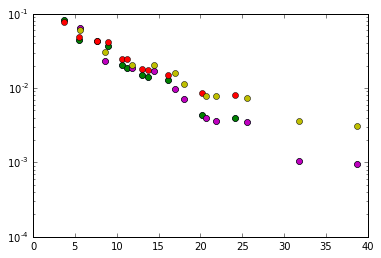

In [45]:
refs=np.array([alphaX_ref,alphaX_ref,alphaZ_ref])
for rVal in box:
    dataset=box[rVal]['eigenproblems']
    refs=np.array([alphaX_ref,alphaX_ref,alphaZ_ref])
    #data=[(nalpha,dataset[nalpha]['alpha_xyz']) for nalpha in dataset]
    data=[(get_alpha_energy(box[rVal]['logfilex'],5,nalpha),dataset[nalpha]['alpha_xyz']) for nalpha in dataset]
    plt.semilogy([HaeV*t[0] for t in data],[(1.0-t[1]/refs)/norb for t in data],'o')

In [48]:
def CRs(logs,numOccOrb,virtMax):
    S_nvirt_Ex = R.evalS_nvirt(logs['logfilex'])
    S_nvirt_Ez = R.evalS_nvirt(logs['logfilez'])
    engvirt=logs['logfilex'].evals[0][0][numOccOrb:numOccOrb+virtMax]
    return engvirt,S_nvirt_Ex,S_nvirt_Ez
for rVal in box:
    box[rVal]['Completeness Relation']=CRs(box[rVal],norb,box[rVal]['nvirt'])

no_occ 5 n_vrt 301
R =  0.00037277440012
no_occ 5 n_vrt 301
R =  0.000534570620831
no_occ 5 n_vrt 301
R =  0.000371753753036
no_occ 5 n_vrt 301
R =  0.000533261680349


In [60]:
def get_alpha_vs_CR(refs,box,rVal,idir):
    dataset=box[rVal]['eigenproblems']
    data=[(get_alpha_energy(box[rVal]['logfilex'],5,nalpha),dataset[nalpha]['alpha_xyz']) for nalpha in dataset]
    plt.semilogy([HaeV*t[0] for t in data],[((1.0-t[1]/refs))[idir] for t in data],'o')
    engvirt,S_nvirt_Ex,S_nvirt_Ez=box[rVal]['Completeness Relation']
    if idir==2: 
        plt.semilogy(HaeV*engvirt,S_nvirt_Ez,label='CREz')
    else:
        plt.semilogy(HaeV*engvirt,S_nvirt_Ex,label='CREx')
    plt.xlabel('energy(eV)')
    plt.legend()

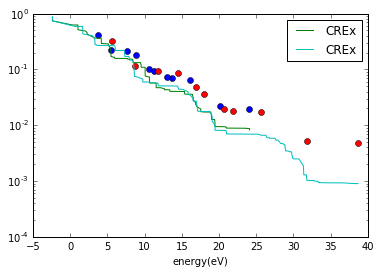

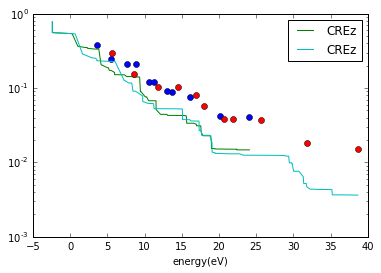

In [65]:
for rVal in box:
    get_alpha_vs_CR(refs,box,rVal,0)
plt.show()
for rVal in box:
    get_alpha_vs_CR(refs,box,rVal,2)

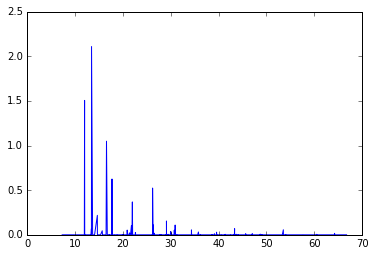

In [75]:
def plot_os(dict_casida):
    e2=dict_casida['eigenvalues']
    os=dict_casida['oscillator_strengths']
    plt.plot(HaeV*np.sqrt(e2),[o[2]/e for o,e in zip(os,e2)])
plot_os(box[7.0]['eigenproblems'][301])

In [76]:
def identify_contributions(numOrb,na,exc,C_E2):
    pProj = np.zeros(numOrb*2)
    for p in range(numOrb):
        for spin in [0,1]:
                # sum over all the virtual orbital and spin 
            for alpha in range(na):                 
                # extract the value of the index of C_E2
                elements = R.transition_indexes([numOrb],[na],[[p,alpha,spin]])
                for el in elements:
                    pProj[p+numOrb*spin] += C_E2[exc][el]**2
    return pProj
def get_threshold(pProj,evals,tol):
    norb=len(evals)
    spinup=pProj[0:norb].tolist()
    spindw=pProj[norb:2*norb].tolist()
    spinup.reverse()
    spindw.reverse()
    imax=norb-1
    for valu,vald in zip(spinup,spindw):
        if max(valu,vald) > tol: break
        imax-=1
    return -evals[imax]

In [109]:
def find_excitation_thr(dict_casida,na,nexc,evals,tol=1.e-3):
    norb=len(evals)
    thrs=[]
    for a in range(nexc):
        proj=identify_contributions(norb,na,a,dict_casida['eigenvectors'])
        th=get_threshold(proj,evals,tol)
        thrs.append(th)
    dict_casida['thresholds']=np.array(thrs)
find_excitation_thr(box[7.0]['eigenproblems'][301],301,1000,box[7.0]['logfilex'].evals[0][0][0:norb],tol=1.e-2)

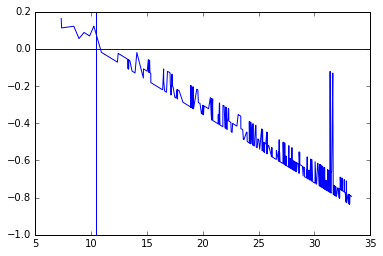

In [111]:
ths=box[7.0]['eigenproblems'][301]['thresholds']
e2=box[7.0]['eigenproblems'][301]['eigenvalues']
ev=box[7.0]['logfilex'].evals
plt.plot([HaeV*np.sqrt(e2[i])for i,th in enumerate(ths)],[th-np.sqrt(e2[i])for i,th in enumerate(ths)])
plt.axhline(0)
plt.axvline(-max(ev[0][0][0:norb])*HaeV)

In [110]:
find_excitation_thr(box[9.0]['eigenproblems'][301],301,2000,box[9.0]['logfilex'].evals[0][0][0:norb],tol=1.e-2)

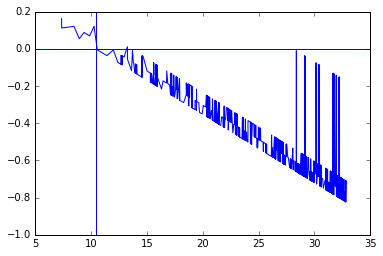

In [108]:
ths=box[9.0]['eigenproblems'][301]['thresholds']
e2=box[9.0]['eigenproblems'][301]['eigenvalues']
ev=box[9.0]['logfilex'].evals
plt.plot([HaeV*np.sqrt(e2[i])for i,th in enumerate(ths)],[th-np.sqrt(e2[i])for i,th in enumerate(ths)])
plt.axhline(0)
plt.axvline(-max(ev[0][0][0:norb])*HaeV)

In [121]:
def regroup_excitations(e2,ths,evals):
    channels=[ [] for e in evals]
    for e,th in zip(e2,ths):
        ind=np.argmin(np.abs(evals+th))
        channels[ind].append(np.sqrt(e))
    return channels
from BigDFT import DoS as D
def get_channels(bb):
    tt=bb['eigenproblems'][bb['nvirt']]
    ev=bb['logfilex'].evals[0][0][0:norb].tolist()
    chs=regroup_excitations(tt['eigenvalues'],tt['thresholds'],np.array(ev))
    chs.reverse()
    return [np.array(ch) for ch in chs]
chs7=get_channels(box[7.0])
chs9=get_channels(box[9.0])
evals=box[9.0]['logfilex'].evals[0][0][0:norb].tolist()

In [122]:
print norb
print [len(ch) for ch in chs7]
print [len(ch) for ch in chs9]
print evals

5
[396, 383, 88, 129, 4]
[702, 740, 185, 352, 21]
[-1.03254081952699, -0.497644769760909, -0.431482672052383, -0.43148266408928, -0.382005077917541]


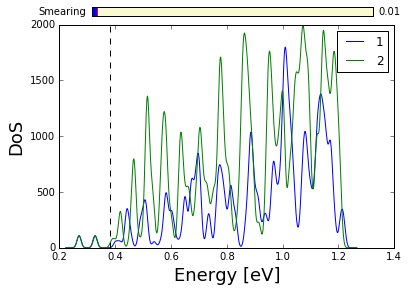

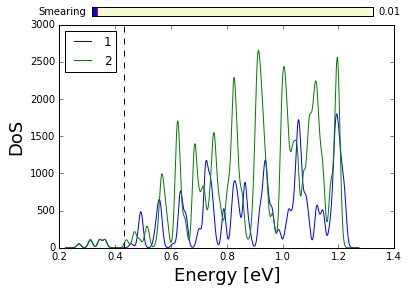

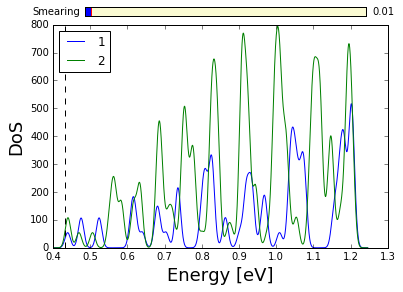

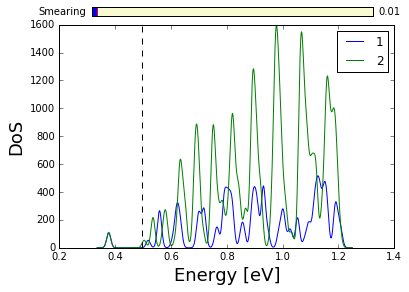

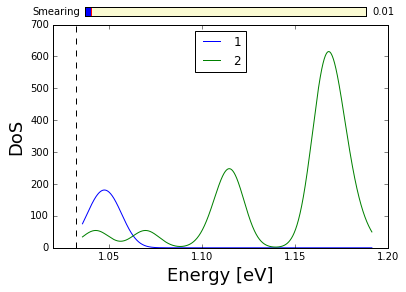

In [129]:
ind=0
for ch7,ch9 in zip(chs7,chs9):
    #align the channels
    delta=ch9[0]-ch7[0]
    ch7+=delta
    dos=D.DoS(energies=ch7,fermi_level=-evals[-1-ind]-delta)
    dos.append(energies=np.array([ch9]))
    ind+=1
    dos.plot()

In [16]:
alphaX = []
alphaY = []
alphaZ = []
virt = [16, 32, 48, 64, 80, 96, 112, 128, 160, 224, virtMax_rmult9]
def get_eigenproblems(virt,Cmat,trans):
    eigenproblems={}
    for nind,nval in enumerate(virt):
        if nval in eigenproblems: continue
        C_ext,dipoles_ext=R.extract_subset([5],[virtMax_rmult9],Cmat,trans,[nval])
        newdipole=[]
        for line in dipoles_ext:
            newdipole.append(line[0]/8.0*np.array(line[1:]))
        newdipole=np.array(newdipole)
        E2,C_E2=np.linalg.eigh(C_ext)
        eigenproblems[nval]=(E2,C_E2,newdipole)
        sumx = 0.0
        sumy = 0.0
        sumz = 0.0   
        for i,e in enumerate(E2):
            a = np.dot(C_E2.T[i],newdipole)
            sumx+=2.0*a[0]*a[0]/e
            sumy+=2.0*a[1]*a[1]/e
            sumz+=2.0*a[2]*a[2]/e
        alphaX.append(sumx)
        alphaY.append(sumy)
        alphaZ.append(sumz)
        print nval,alphaX[-1],alphaY[-1],alphaZ[-1]
    return eigenproblems,[alphaX,alphaY,alphaZ]
print alphaX
#print alphaY #to check if it equal to alphaX, ok!
print alphaZ
eigenproblems7,alpha7=get_eigenproblems(virt,Cmat7,trans7)

NameError: name 'virtMax_rmult9' is not defined

In [242]:
alphaX_norm = [i/alphaX_ref for i in alpha7[0]]
alphaZ_norm = [i/alphaZ_ref for i in alpha7[2]]

In [246]:
def get_excit(eigenproblems,nval):
    E2,C_E2,newdipole=eigenproblems[nval]
    excit=[]
    for i,e in enumerate(E2):
        a = np.dot(C_E2.T[i],newdipole)
        excit.append(a)
    return E2,np.array(excit)

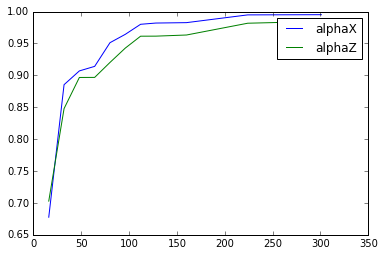

In [243]:
%matplotlib inline
plt.plot(virt,alphaX_norm,label='alphaX')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.plot(virt,alphaZ_norm,label='alphaZ')
plt.legend()
plt.show()

In [229]:
spreadX = []
spreadY = []
spreadZ = []
virt = [16, 32, 48, 64, 80, 96, 112, 128, 160, 224, virtMax_rmult7]
for nind,nval in enumerate(virt):
    E2,C_E2,newdipole=eigenproblems[nval]
    excit=[]
    sumx = 0.0
    sumy = 0.0
    sumz = 0.0   
    for i,e in enumerate(E2):
        a = np.dot(C_E2.T[i],newdipole)
        excit.append(a)
        #print len(a),a[6:9]
        r2 = np.array(a[6:9])
        r = np.array(a[0:3])
        spread = r2
        sumx+=2.0*spread[0]*a[0]/e
        sumy+=2.0*spread[1]*a[1]/e
        sumz+=2.0*spread[2]*a[2]/e
    spreadX.append(sumx)
    spreadY.append(sumy)
    spreadZ.append(sumz)
    print nval,spreadX[-1],spreadY[-1],spreadZ[-1]
    excit=np.array(excit)
print [ s/5.0 for s,d in zip(spreadX,alphaX)]
print [ s/5.0 for s,d in zip(spreadZ,alphaZ)]

16 0.0453344664465 0.0453344664466 -0.0390877390544
32 -0.0145576566045 -0.0145576566044 -0.0465209782177
48 -0.0128967281977 -0.0128967281977 -0.0684329430591
64 -0.00824844234802 -0.00824844234799 -0.0996578641228
80 -0.00837423056746 -0.00837423056744 -0.0290927235172
96 -0.00169867239852 -0.00169867239848 -0.0290890601632
112 0.0073833290644 0.00738332906443 -0.0147789189064
128 -0.00161571949686 -0.00161571949682 -0.0444621076282
160 -0.0183446547849 -0.0183446547849 0.0237155989457
224 0.0130539655561 0.0130539655561 -0.000120678597388
301 -0.00802980251925 -0.00802978119226 -0.0169591895245
[0.0090668932893007044, -0.0029115313208950989, -0.0025793456395396342, -0.0016496884696038997, -0.0016748461134927736, -0.00033973447970383298, 0.0014766658128801554, -0.00032314389937163117, -0.0036689309569786638, 0.0026107931112174299, -0.0016059605038501797]
[-0.0078175478108766707, -0.0093041956435428643, -0.013686588611815379, -0.019931572824558826, -0.0058185447034333742, -0.005817812

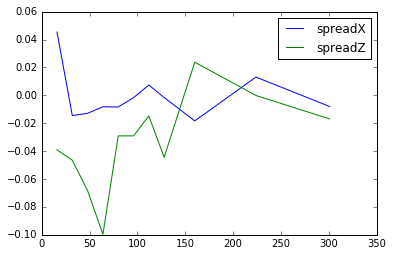

In [230]:
%matplotlib inline
plt.plot(virt,spreadX,label='spreadX')
plt.plot(virt,spreadZ,label='spreadZ')
plt.legend()
plt.show()

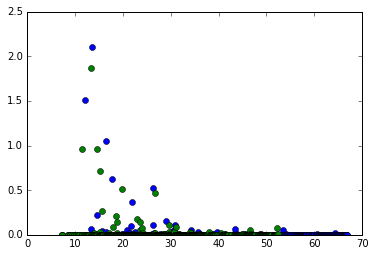

In [301]:
E27,a7=get_excit(eigenproblems7,virtMax_rmult7)
E29,a9=get_excit(eigenproblems,virtMax_rmult9)
for i in [2]: #range(len(excit[0])):
    plt.plot(27.211*np.sqrt(E27),np.array([a[i]*a[i] for a in a7])/E27,'o')
    plt.plot(27.211*np.sqrt(E29),np.array([a[i]*a[i] for a in a9])/E29,'o')
#plt.xlim([0,25])

lenE2 3010 omegaMax 66.7766900423
lenE2 3010 omegaMax 52.5238985668


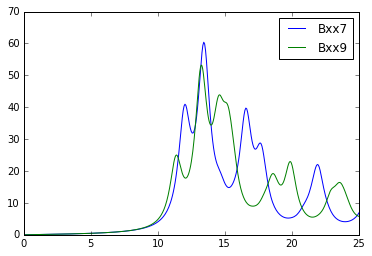

In [285]:
def get_spectrum(excit):
    npoint = 1000
    eta = 1.0e-2
    E2,a=excit
    omegaMax = np.sqrt(E2[-1]) #square root of the highest eigenvalues
    print 'lenE2', len(E2), 'omegaMax', omegaMax*27.211
    o=np.linspace(0.0,omegaMax,npoint)
    s = 0.0
    for e,tr in zip(E2,a):
        s+=2.0*tr[2]*tr[2]/((o+1j*2.0*eta)**2-e)
    return o,s
o7,Rxx7=get_spectrum(get_excit(eigenproblems7,virtMax_rmult7))
o9,Rxx9=get_spectrum(get_excit(eigenproblems,virtMax_rmult9))
#plt.plot(27.211*o7,-np.real(Rxx7),label='Cxx7')
#plt.plot(27.211*o9,-np.real(Rxx9),label='Cxx9')
plt.plot(27.211*o7,-np.imag(Rxx7),label='Bxx7')
plt.plot(27.211*o9,-np.imag(Rxx9),label='Bxx9')
plt.xlim([0,25])
plt.legend(loc='best')

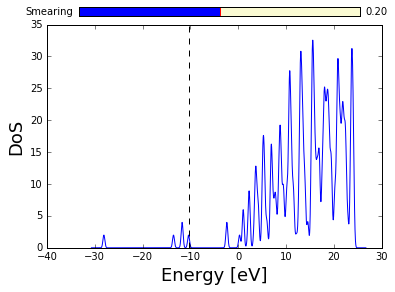

[-1.03254082 -0.49764477 -0.43148267 -0.43148266 -0.38200508]


In [351]:
log=lf.Logfile('linear-response/log/log-NumVirt_301.yaml')
log.get_dos().plot()
evals=log.evals[0][0][0:5]
print evals

In [492]:
E29,C_E29,newdipole9=eigenproblems[virtMax_rmult9]
i=7
print np.allclose(Cmat.dot(C_E29[i].T),E29[i]*C_E29[i].T)
print identify_contributions(5,virtMax_rmult9,i,C_E29),HaeV*np.sqrt(E29[i])

False
[  9.15957692e-07   2.01294996e-06   6.59457636e-07   1.67780715e-05
   1.76600061e-05   9.99906817e-01   2.21172995e-05   2.62246674e-05
   4.50319754e-06   2.31119325e-06] 9.34956403623


In [434]:
E29,C_E2,newdipole=eigenproblems[virtMax_rmult9]
ths=[]
mask=[]
for i,e2 in enumerate(E2):
    #maxval=max(-evals)
    #if np.sqrt(e2) > maxval:
    #    mask.append(False)
    #    ths.append(maxval)
    #    continue
    w=identify_contributions(5,virtMax_rmult9,i,C_E2)
    #print w,sum(w)
    th=get_threshold(w,evals,5.e-3)
    ths.append(th)
    islow=th > np.sqrt(e2)
    mask.append(islow)
    

In [435]:
E27,C_E2,newdipole=eigenproblems7[virtMax_rmult7]
ths7=[]
mask7=[]
for i,e2 in enumerate(E2):
    #maxval=max(-evals)
    #if np.sqrt(e2) > maxval:
    #    mask7.append(False)
    #    ths7.append(maxval)
    #    continue
    w=identify_contributions(5,virtMax_rmult7,i,C_E2)
    #print w,sum(w)
    th=get_threshold(w,evals,5.e-3)
    ths7.append(th)
    islow=th > np.sqrt(e2)
    mask7.append(islow)

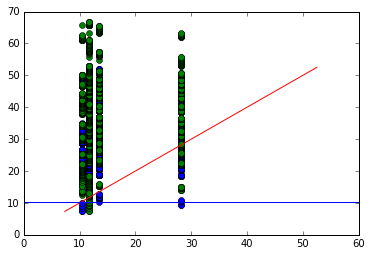

In [436]:
HaeV=27.211
plt.plot(HaeV*np.array(ths),HaeV*np.sqrt(E29),'o')
plt.plot(HaeV*np.array(ths7),HaeV*np.sqrt(E27),'o')
plt.plot(HaeV*np.sqrt(E29),HaeV*np.sqrt(E29))
plt.axhline(-max(evals)*HaeV)

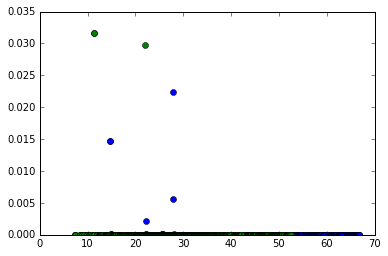

In [427]:
plt.plot(HaeV*np.sqrt(E27),[ 0 if not a else f[0]*f[0] for f,a in zip(a7,mask7)],'o')
plt.plot(HaeV*np.sqrt(E29),[ 0 if not a else f[0]*f[0] for f,a in zip(a9,mask)],'o')

(0, 30)

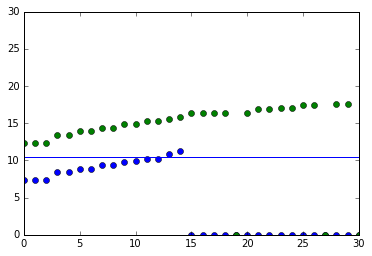

In [440]:
plt.plot([ 0 if not a else HaeV*np.sqrt(e2) for e2,a in zip(E27,mask7)],'o')
plt.plot([ 0 if not a else HaeV*np.sqrt(e2)+5 for e2,a in zip(E29,mask)],'o')
plt.axhline(-max(evals)*HaeV)
plt.xlim([0,30])

To check the correctness of the procedure for the construcion of the coupling matrix (given the one with the highest number of virtual orbitals) we compare some of the result obtained above with the ones build in terms of the true coupling matrix computed with 16 and 32 virtual orbitals.

Results agree with those obtained by the application of the "extract_subset" routine.

### Dynamical polarizability in the adiabatic case for Rmult=7.0

We plot the imaginary part of (minus) $A(\omega_0)$ using the coupling matrix e transition dipoles in function of the number of virtual orbitals considered in the computation. In particular we want to compare results for numVirt = 64,128,virtMax

In [293]:
npoint = 1000
eta = 1.0e-2
omega = []
A = []
virt = [64,128,virtMax_rmult7]
for ii,nVal in enumerate(virt):
    if nVal not in eigenproblems:
        C_ext,dipoles_ext=R.extract_subset([5],[virtMax_rmult7],Cmat7,trans7,[nVal])
        E2,C_E2=np.linalg.eigh(C_ext)
        print 'we should recalulate the value:',nVal
        newdipole=[]
        for line in dipoles_ext:
            newdipole.append(line[0]/8.0*np.array(line[1:]))
        newdipole=np.array(newdipole)
        eigenproblems[nVal]=(E2,C_E2,newdipole)
        dipoles_ext=newdipole
    else:
        E2,C_E2,dipoles_ext=eigenproblems[nVal]
    omegaMax = np.sqrt(E2[-1]) #square root of the highest eigenvalues
    print 'lenE2', len(E2), 'omegaMax', omegaMax
    omega.append(np.linspace(0.0,omegaMax,npoint))
    A_nVirt = np.zeros(npoint, dtype=complex)
    fE = []
    fS = []
    fQ = []
    for i in range(len(E2)):
        z=np.dot(C_E2.T[i],dipoles_ext[:,2])
        z2=np.dot(C_E2.T[i],dipoles_ext[:,8])
        fE.append(z*z)#2)
        fS.append(z*z2)
        fQ.append(z2*z2)
    for ind,o in enumerate(omega[ii]):
        s = 0.0
        for i,e in enumerate(E2):
            s+=2.0*fE[i]/(complex(o,2*eta)**2-e)
        A_nVirt[ind] = s
    A.append(-np.imag(A_nVirt))

lenE2 640 omegaMax 1.35957659044
lenE2 1280 omegaMax 1.53623398023
lenE2 3010 omegaMax 1.93024506879


In [294]:
omega_ev = []
for i in range(len(omega)):
    omega_ev.append(27.211*omega[i])

lenE2 3010 omegaMax 66.7766900423
lenE2 3010 omegaMax 52.5238985668


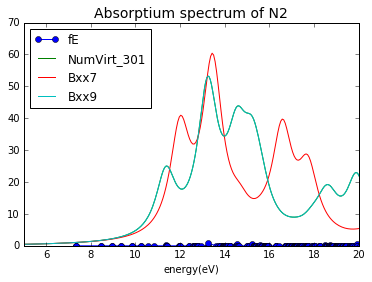

In [299]:
%matplotlib inline
#for i in range(len(virt)):
#    plt.plot(omega_ev[i],A[i],'-o',label='NumVirt_'+str(virt[i]))
plt.plot(27.211*np.sqrt(E2),abs(2.0*np.array(fE)),'-o',label='fE')
#plt.plot(27.211*np.sqrt(E2),abs(2.0*np.array(fQ)),'-o',label='fQ')
#plt.plot(27.211*np.sqrt(E2),10*2.0*np.array(fS),'-o',label='fS')
i=len(virt)-1
plt.plot(omega_ev[i],A[i],label='NumVirt_'+str(virt[i]))
o7,Rxx7=get_spectrum(get_excit(eigenproblems7,virtMax_rmult7))
plt.plot(27.211*o7,-np.imag(Rxx7),label='Bxx7')
o9,Rxx9=get_spectrum(get_excit(eigenproblems,virtMax_rmult9))
plt.plot(27.211*o9,-np.imag(Rxx9),label='Bxx9')
plt.legend(loc='best')
plt.xlabel('energy(eV)')
plt.xlim((5,20))
#plt.ylim((0,1.8))
plt.title('Absorptium spectrum of N2', fontsize=14)
plt.show()

### Stability of the results vs. size of the simultation box

We analyze the convergence of the statical polarizability to the reference value for Rmult = 9.0

In [50]:
%cd $outputpath
dpath = 'log/TDDFT-Results/transition_dipoles_rmult=9.0_279.txt'
dipoles = np.loadtxt(dpath)
cpath = 'log/TDDFT-Results/coupling_matrix_rmult=9.0_279.txt'
C = np.loadtxt(cpath)
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


In [52]:
virtMax_rmult9 = 279

In [53]:
alphaX = []
alphaY = []
alphaZ = []
virt = [16, 32, 48, 64, 80, 96, 112, 128, 160, 224, 256, virtMax_rmult9]
for nind,nval in enumerate(virt):
    C_ext,dipoles_ext=R.extract_subset([5],[virtMax_rmult9],C,dipoles,[nval])
    E2,C_E2=np.linalg.eigh(C_ext)
    sumx = 0.0
    sumy = 0.0
    sumz = 0.0
    for i,e in enumerate(E2):
        a = np.dot(C_E2.T[i],dipoles_ext)
        sumx+=2.0*a[0]*a[0]/e
        sumy+=2.0*a[1]*a[1]/e
        sumz+=2.0*a[2]*a[2]/e
    alphaX.append(sumx)
    alphaY.append(sumy)
    alphaZ.append(sumz)
print alphaX
#print alphaY #to check if it equal to alphaX, ok!
print alphaZ

[6.4626561123892055, 8.4354956508710313, 8.5663026715236121, 8.8642454775988888, 9.7611222584797162, 9.8721503816250493, 10.059414788310804, 10.10099456101829, 10.171737615659101, 10.631972230523898, 10.643056253792423, 10.643700998141032]
[6.462656112388987, 8.4354956508708288, 8.5663026715234416, 8.8642454775987005, 9.7611222584795581, 9.8721503816248806, 10.05941478831066, 10.10099456101814, 10.171737615658966, 10.631972230523809, 10.643056253792249, 10.643701005208033]
[9.7087505567632615, 11.882177668613133, 12.411397249705038, 12.451605332609098, 13.813491067570668, 13.814027204686461, 14.315673257169275, 14.341833122951826, 14.546232505676423, 15.070483556366511, 15.074267132648856, 15.092620758654903]


In [54]:
alphaX_ref = 10.87
alphaZ_ref = 15.736

In [55]:
alphaX_norm = [i/alphaX_ref for i in alphaX]
alphaZ_norm = [i/alphaZ_ref for i in alphaZ]

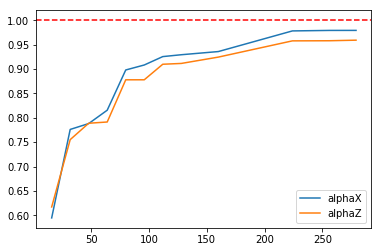

In [56]:
%matplotlib inline
plt.plot(virt,alphaX_norm,label='alphaX')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.plot(virt,alphaZ_norm,label='alphaZ')
plt.legend()
plt.show()

We compare the absorption spectrum

In [45]:
%cd $outputpath
dpath = ['log/TDDFT-Results/transition_dipoles_303.txt','log/TDDFT-Results/transition_dipoles_rmult=9.0_279.txt']
cpath = ['log/TDDFT-Results/coupling_matrix_303.txt','log/TDDFT-Results/coupling_matrix_rmult=9.0_279.txt']
npoint = 1000
eta = 1.0e-2
omega = []
A = []

for ii in range(len(dpath)):
    dipoles = np.loadtxt(dpath[ii])
    C = np.loadtxt(cpath[ii])
    E2,C_E2=np.linalg.eigh(C)
    omegaMax = np.sqrt(E2[-1])
    print 'lenE2', len(E2), 'omegaMax', omegaMax
    omega.append(np.linspace(0.0,omegaMax,npoint))
    A_nVirt = np.zeros(npoint, dtype=complex)
    fE = []
    for i in range(len(E2)):
        fE.append(np.dot(C_E2.T[i],dipoles[:,2]))
    for ind,o in enumerate(omega[ii]):
        s = 0.0
        for i,e in enumerate(E2):
            s+=fE[i]**2/(complex(o,2*eta)**2-e)
        A_nVirt[ind] = s
    A.append(-np.imag(A_nVirt))
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
lenE2 3030 omegaMax 2.46915758956
lenE2 2790 omegaMax 1.92260078949
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


In [46]:
omega_ev = []
for i in range(len(omega)):
    omega_ev.append(27.211*omega[i])

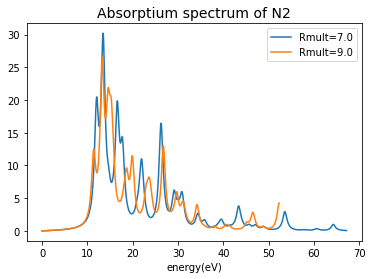

In [48]:
%matplotlib inline
lab = ['7.0','9.0']
for i in range(len(dpath)):
    plt.plot(omega_ev[i],A[i],label='Rmult='+lab[i])
plt.legend()
plt.xlabel('energy(eV)')
plt.title('Absorptium spectrum of N2', fontsize=14)
plt.show()